In [1]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=65226cb9654200d353a65ce91cdfaa9b308e1ea874be26b25275ea95c83f9b5f
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from PIL import Image
import albumentations
from albumentations import pytorch as AT
from collections import OrderedDict

import os
import random

import pretrainedmodels


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(1234)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
path = "../input/android-and-apple-smartphones-images/"
os.listdir(path)

def create_filelist(path):
    filelist = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            filelist.append(os.path.join(dirname, filename))
    return filelist

In [7]:
android_train = path + "Android_train/"
android_test = path + "android_test/"
iphone_train = path + "Iphone_train/"
apple_test = path + "apple_test/"

['../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (17).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (34).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (1).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (9).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (28).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (32).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (3).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (8).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (29).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (22).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (31).jpg', '../input/android-and-apple-smartphones-images/apple_test/apple_test/0 (2).jpg', '../input/android-an

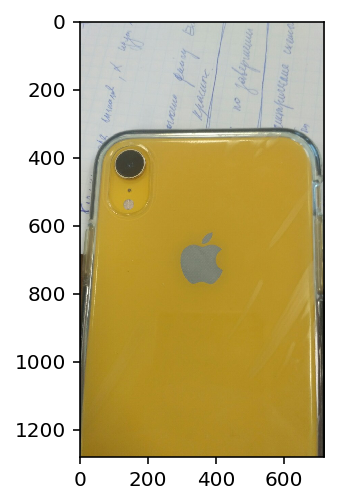

In [8]:
create_filelist(apple_test)[0]
print(create_filelist(apple_test))
plt.imshow(Image.open(create_filelist(apple_test)[1]))

In [9]:
model = pretrainedmodels.__dict__["se_resnext50_32x4d"](num_classes=1000, pretrained=None)
model.load_state_dict(torch.load("../input/se-resnext-pytorch-pretrained/se_resnext50_32x4d-a260b3a4.pth"))
model.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
model.last_linear = nn.Linear(2048, 2)


In [10]:
class SmartphoneDataset(Dataset):
    
    def __init__(self, filelist, transforms = None, mode="train"):
        self.filelist = filelist
        self.transforms = transforms
        self.mode = mode
        if self.mode == "train":
            self.label = 1  if "Android_train" in self.filelist[0] else 0
            
    def __len__(self):
        return len(self.filelist)
    
    
    def __getitem__(self, idx):
        image_source = self.filelist[idx]
        image = cv2.imread(image_source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image=image)
        if self.mode == "train":
            return image["image"], self.label
        else:
            return image["image"], self.filelist[idx]
        
        


In [11]:
img_size = 224

data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    #albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    #albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

In [12]:
android_dataset = SmartphoneDataset(create_filelist(android_train), transforms = data_transforms)
iphone_dataset = SmartphoneDataset(create_filelist(iphone_train), transforms = data_transforms)
test_android_dataset = SmartphoneDataset(create_filelist(android_test), transforms = data_transforms_test, mode = "test")
test_apple_dataset = SmartphoneDataset(create_filelist(apple_test), transforms = data_transforms_test, mode = "test")
train_dataset = ConcatDataset([android_dataset, iphone_dataset ])
test_dataset = ConcatDataset([test_android_dataset, test_apple_dataset ])

In [13]:
batch_size = 32
num_workers = 0



train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True )
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True )

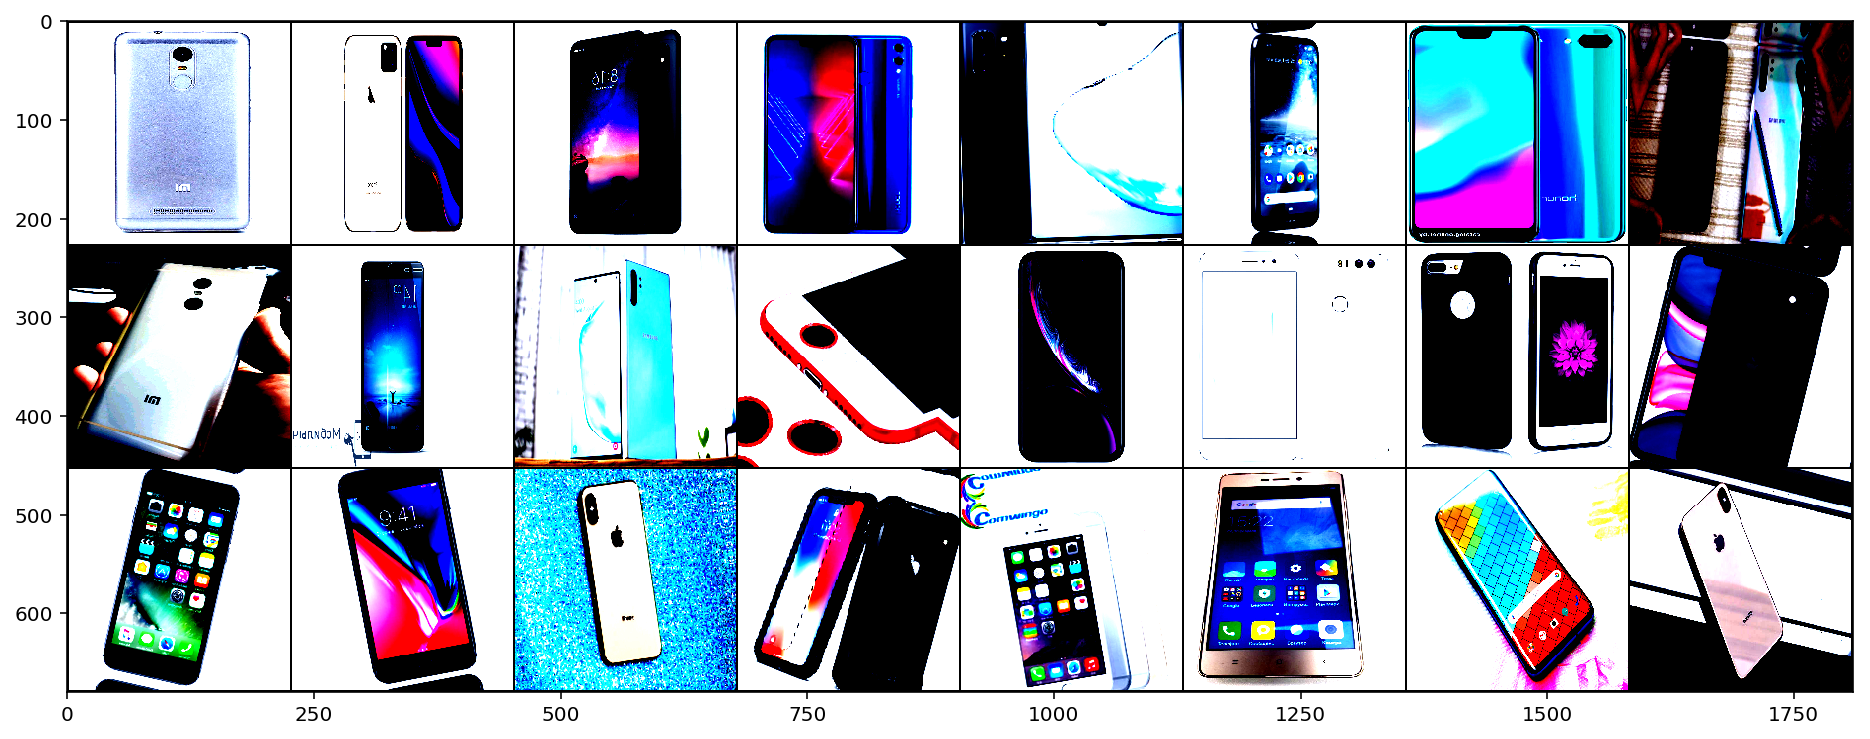

In [14]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.15, patience = 2)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [16]:
def train_model(model, criterion, optimizer, dataloader, num_epochs=15):
    model.to(device)
    train_loss = []
    loss_min = np.Inf
    patience = 5
    stop = False
    for epoch in range(1, num_epochs+1):
        
        running_loss = 0
        correct_samples = 0
        total_samples = 0
        
        for i, (image, label) in enumerate(dataloader):
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(image)
            
            loss = criterion(output, label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            _, indices = torch.max(output, 1)
            correct_samples += torch.sum(indices == label)
            total_samples += label.shape[0]
            train_accuracy = float(correct_samples) / total_samples
            
            
            
            
        scheduler.step()   
        print("Epoch : {}/{}..".format(epoch,num_epochs), "Training Loss: {:.6f}".format(running_loss/len(dataloader)), "Acc: {:.6f}".format(train_accuracy))
        train_loss.append(running_loss)
        
        if  running_loss <= loss_min:
            print('Loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            loss_min,
            running_loss))
            torch.save(model.state_dict(), 'model.pt')
            loss_min = running_loss
            p = 0
        
        if running_loss > loss_min:
            p += 1
            print(f'{p} epochs of increasing loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    plt.plot(train_loss, label = "Training Loss")
    plt.show()
    return model
                  

Epoch : 1/30.. Training Loss: 0.532160 Acc: 0.765415
Loss decreased (inf --> 23.947181).  Saving model ...
Epoch : 2/30.. Training Loss: 0.331849 Acc: 0.864635
Loss decreased (23.947181 --> 14.933202).  Saving model ...
Epoch : 3/30.. Training Loss: 0.292623 Acc: 0.909993
Loss decreased (14.933202 --> 13.168042).  Saving model ...
Epoch : 4/30.. Training Loss: 0.162821 Acc: 0.945429
Loss decreased (13.168042 --> 7.326955).  Saving model ...
Epoch : 5/30.. Training Loss: 0.116492 Acc: 0.949681
Loss decreased (7.326955 --> 5.242155).  Saving model ...
Epoch : 6/30.. Training Loss: 0.109137 Acc: 0.970234
Loss decreased (5.242155 --> 4.911179).  Saving model ...
Epoch : 7/30.. Training Loss: 0.064744 Acc: 0.982991
Loss decreased (4.911179 --> 2.913458).  Saving model ...
Epoch : 8/30.. Training Loss: 0.049709 Acc: 0.985826
Loss decreased (2.913458 --> 2.236911).  Saving model ...
Epoch : 9/30.. Training Loss: 0.037341 Acc: 0.987952
Loss decreased (2.236911 --> 1.680342).  Saving model ...


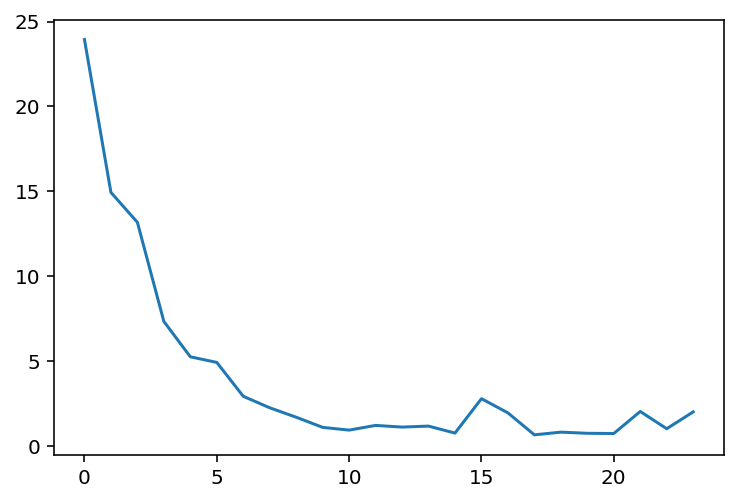

In [17]:
trained_model = train_model(model, criterion, optimizer, train_loader, num_epochs = 30)

In [18]:
trained_model.eval()
fn_list = []
pred_list = []
for image, filename in test_loader:
    with torch.no_grad():
        image = image.to(device)
        output = trained_model(image)
        pred = torch.argmax(output, dim=1)
        fn_list += [n for n in filename]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list, "fin": 0})
submission.to_csv('preds.csv', index=False)

In [19]:
submission.head()

,id,label,fin
0,../input/android-and-apple-smartphones-images/...,0,0
1,../input/android-and-apple-smartphones-images/...,0,0
2,../input/android-and-apple-smartphones-images/...,1,0
3,../input/android-and-apple-smartphones-images/...,1,0
4,../input/android-and-apple-smartphones-images/...,1,0


In [20]:
for i in range(len(submission)):
    if "input/android-and-apple-smartphones-images/android_test/android_test/" in submission.loc[i, "id"]: 
        submission.iloc[i, 2] = 1
    else:
        submission.iloc[i, 2] = 0
        
        
correct_samples = 0
correct_samples += np.sum(submission["fin"] == submission["label"])
total_samples = submission["label"].shape[0]
acc = float(correct_samples)/total_samples
print(acc)

0.9012345679012346


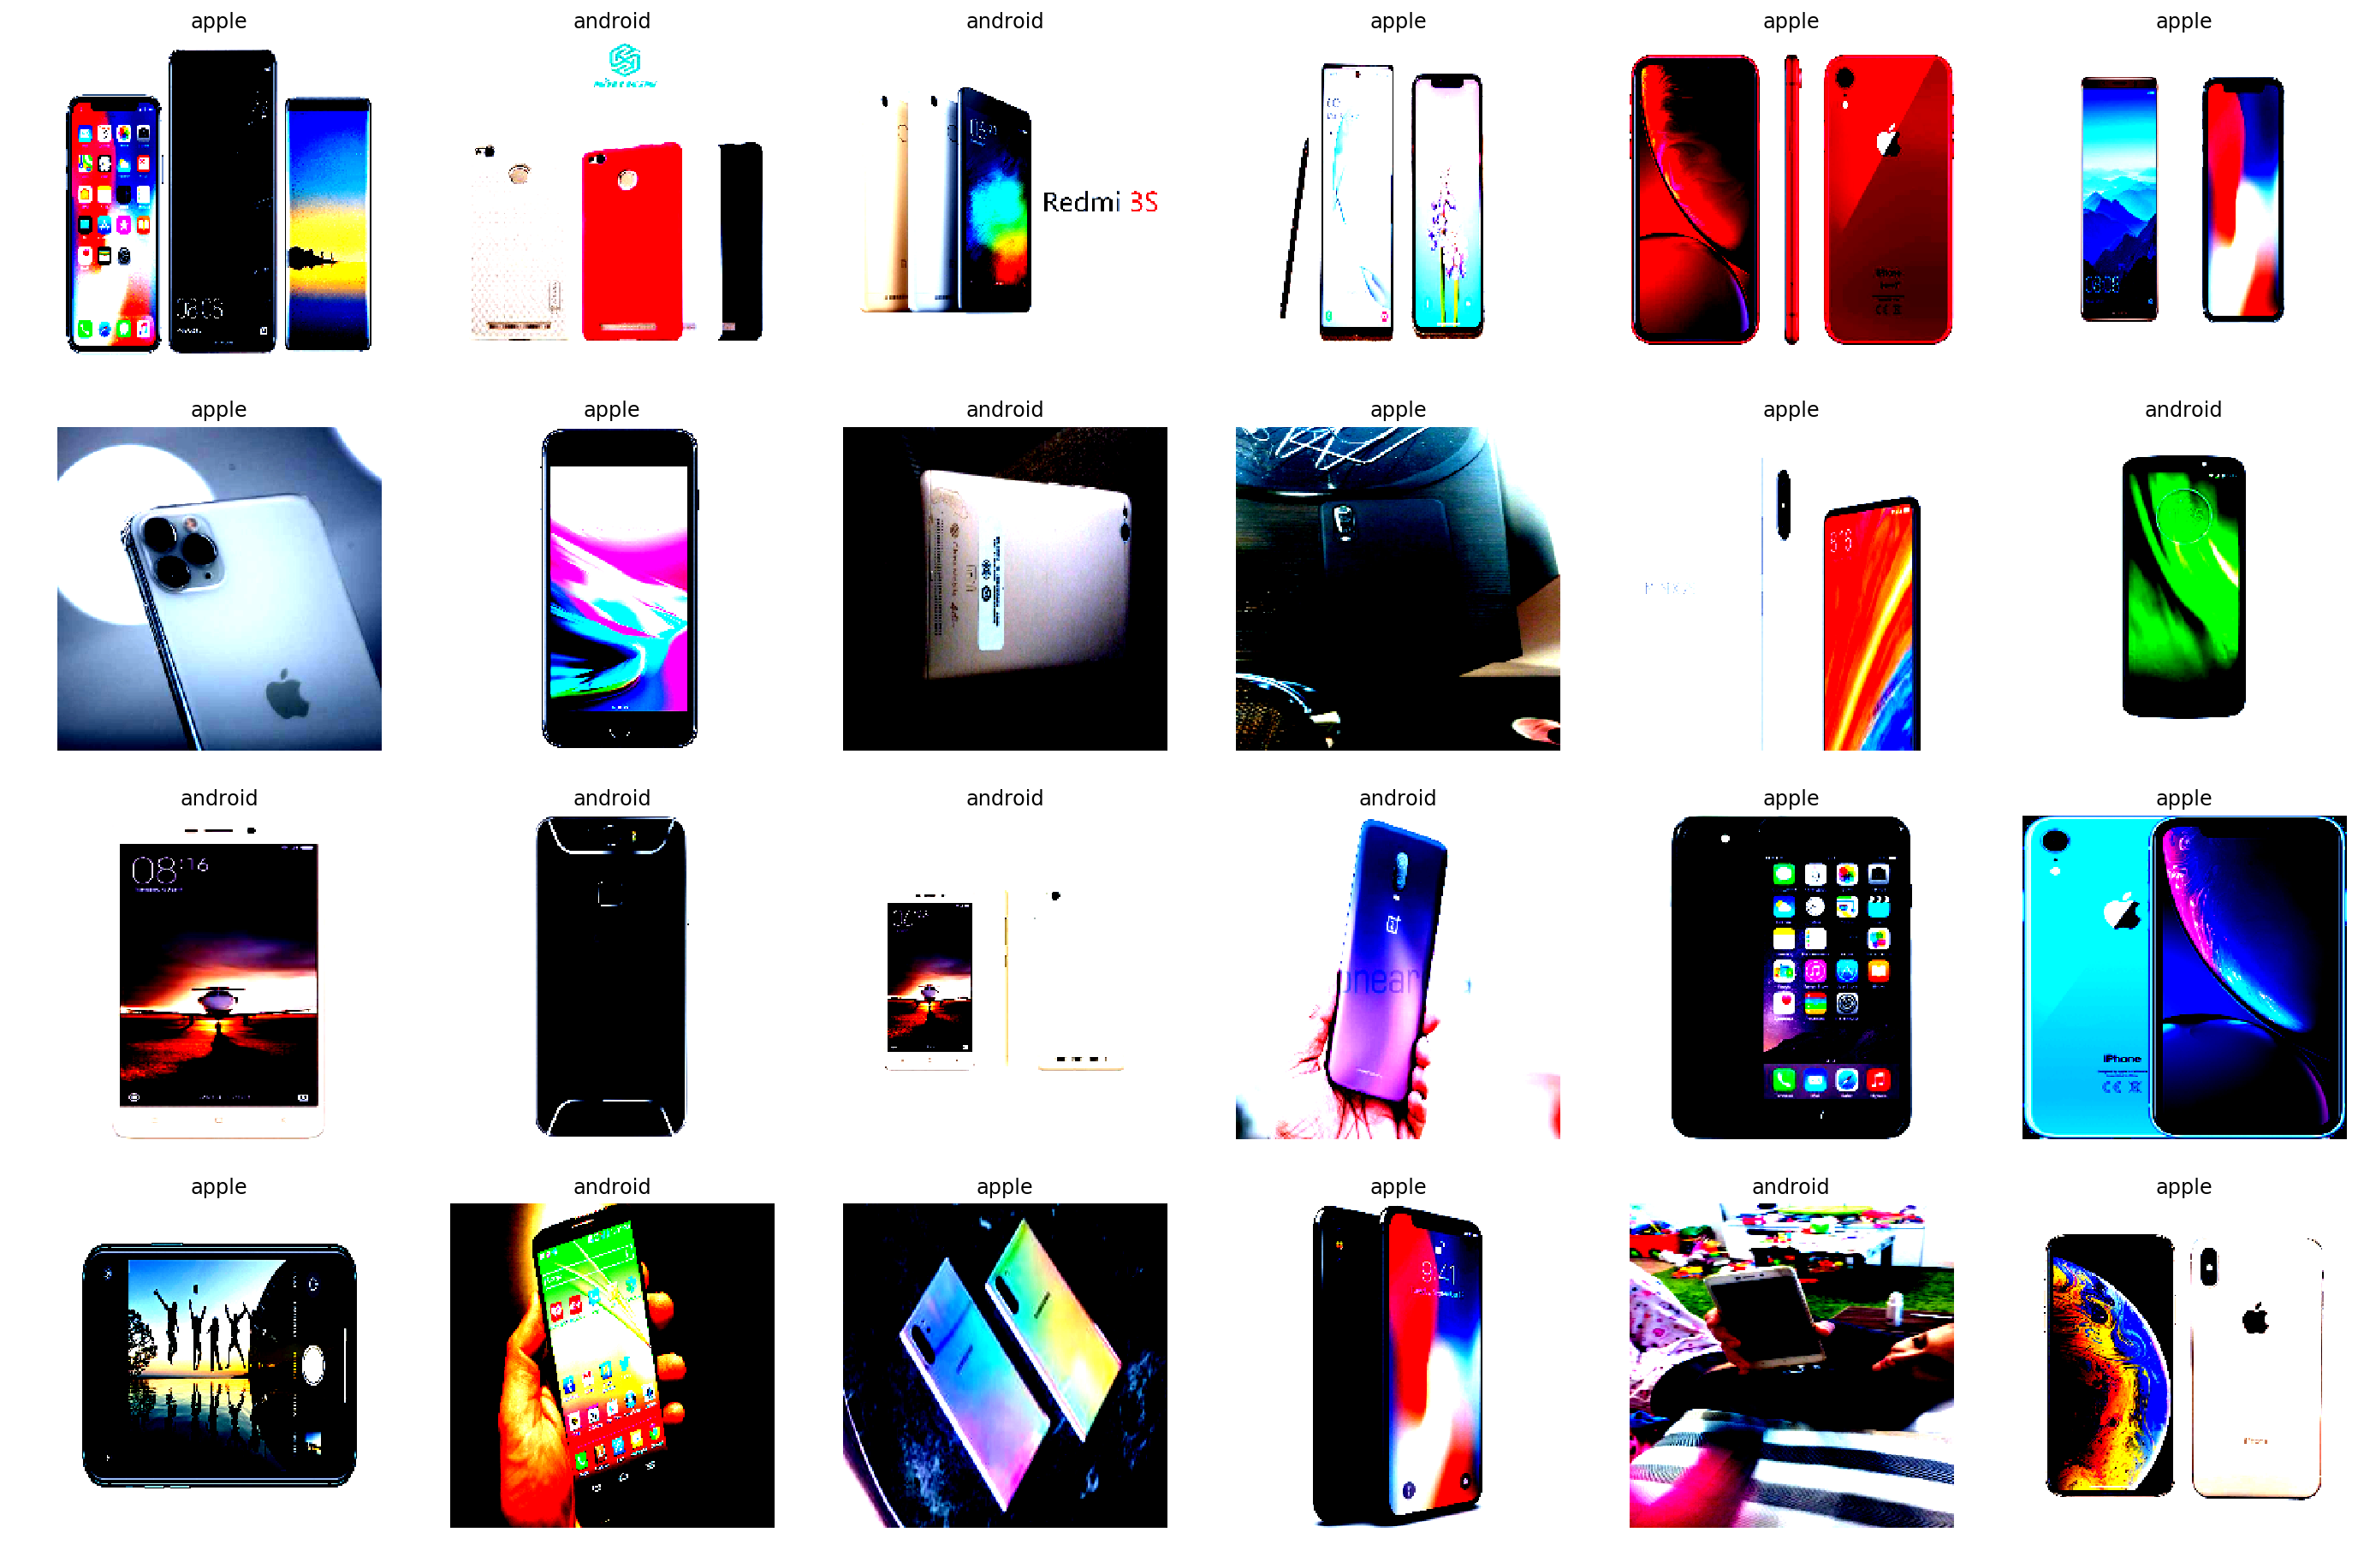

In [21]:
samples, _ = iter(test_loader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'apple', 1:'android'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))